In [1]:
from functools import partial

import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sklearn.linear_model
import torch

import loader
from models import MLPClassifier, BinningCalibrator
import utils

split_ratio_test = 0.3
split_ratio_postproc = 0.1  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 38)

# This seed controls the randomness during pre-training (fixed)
seed_pretrain = 33

# Settings for calibration
n_bins_calib = 100
prior_strength_calib = 1
calibrator_factory = partial(BinningCalibrator,
                             n_bins=n_bins_calib,
                             prior_strength=prior_strength_calib)

max_workers = 32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

data_dir = "data/acsincome"

In [2]:
## Load ACSIncome dataset from `folktables`

(inputs_df, labels, label_names, groups, group_names) = loader.cache_dataset(
    f"{data_dir}/acsincome5.pkl", lambda: loader.load_acsincome(
        data_dir,
        n_classes=5,
        sensitive_attr='RAC1P',
    ))
display(loader.dataset_stats(labels, label_names, groups, group_names))

n_classes = len(label_names)
n_groups = len(group_names)

inputs = np.array(inputs_df.values, dtype=np.float32, copy=True)
inputs_df.drop(columns=list(inputs_df.filter(regex=f'^RAC1P_')), inplace=True)
inputs_u = inputs_df.values.astype(np.float32)

Group,White alone,Black or African American alone,American Indian or Alaska Native alone,"Asian, Native Hawaiian or Other Pacific Islander alone",Other
Target,,,,,
"[0, 15000.0)",233290,36347,3883,18727,26646
"[15000.0, 30000.0)",232268,35779,3803,16333,27630
"[30000.0, 48600.0)",284095,34890,3652,17202,24060
"[48600.0, 78030.0)",273015,24328,2296,17719,15618
"[78030.0, inf)",275458,16229,1263,29231,10738


In [3]:
## Split data into (test + post-processing) and pre-training sets

(inputs_, inputs_pretrain, inputs_u_, inputs_u_pretrain, labels_,
 labels_pretrain, groups_,
 groups_pretrain) = sklearn.model_selection.train_test_split(
     inputs,
     inputs_u,
     labels,
     groups,
     test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
     random_state=seed_pretrain,
 )

# Encode the joint (A, Y) labels by flattening
labels_ay_pretrain = groups_pretrain * n_classes + labels_pretrain

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
inputs_pretrain = scaler.fit_transform(inputs_pretrain)
inputs_ = scaler.transform(inputs_)

scaler = sklearn.preprocessing.StandardScaler()
inputs_u_pretrain = scaler.fit_transform(inputs_u_pretrain)
inputs_u_ = scaler.transform(inputs_u_)

n_samples = len(inputs)
n_test = int(n_samples * split_ratio_test)

## Logistic regression

In [4]:
# Train attribute-aware p(Y | X) predictor
predictor_y = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Binned ECE of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Binned ECE of attribute-blind predictor: 0.7913121023009062


In [5]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

Code for post-processing a single model (with precomputed probas):

    postprocessor = postprocess.PostProcessor(
        n_classes,
        n_groups,
        pred_ay_fn=lambda x: x,  # dummy pred_fn
        criterion='sp',
        alpha=alpha,
        seed=seed,
    )
    postprocessor.fit(probas_ay_postproc)
    preds = postprocessor.predict(probas_ay_test)


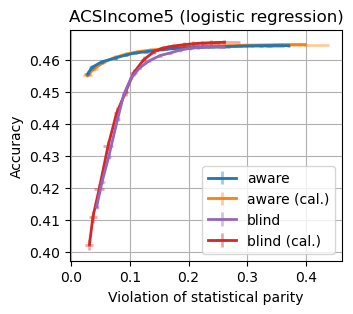

Results for attribute-aware setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.464564  0.000259  0.370922  0.002360     0.190931  0.001239
0.360  0.464595  0.000249  0.347344  0.015449     0.180763  0.006747
0.340  0.464580  0.000266  0.331930  0.011299     0.174508  0.004671
0.320  0.464550  0.000260  0.317070  0.010030     0.168425  0.004010
0.300  0.464466  0.000243  0.298330  0.011073     0.160901  0.003892
0.280  0.464353  0.000255  0.279483  0.011664     0.154233  0.003821
0.260  0.464260  0.000242  0.259786  0.010209     0.148006  0.003139
0.240  0.464167  0.000271  0.241049  0.009270     0.142553  0.002976
0.220  0.464031  0.000257  0.220209  0.008328     0.137592  0.002544
0.200  0.463887  0.000258  0.200110  0.006831     0.133602  0.002066
0.180  0.463724  0.000279  0.181148  0.006154     0.129590  0.002498
0.160  0.463433  0.000270  0.162383  0.003055     0.125814  0.003755
0.140  0.463096  0.000370  0.146087  0.002930     0.114195  0.004495
0.120  0.462649  0.000358  0.127451  0.005455     0.097424  0.004219
0.100  0.462259  0.000378  0.108860  0.003272     0.087809  0.001985
0.080  0.461624  0.000447  0.093546  0.003420     0.075483  0.003505
0.060  0.460708  0.000522  0.075407  0.003346     0.058219  0.003697
0.040  0.459473  0.000640  0.051950  0.003776     0.040399  0.004608
0.020  0.457790  0.000712  0.035344  0.005448     0.023719  0.003961
0.001  0.455798  0.000774  0.028151  0.006167     0.016388  0.003235

Results for attribute-aware setting with calibration:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.464891  0.000348  0.399230  0.040838     0.224149  0.036293
0.360  0.464897  0.000335  0.356449  0.014845     0.208587  0.026884
0.340  0.464796  0.000318  0.336112  0.014574     0.199716  0.028888
0.320  0.464735  0.000336  0.315551  0.015040     0.192213  0.031019
0.300  0.464695  0.000314  0.296160  0.013172     0.184568  0.032435
0.280  0.464584  0.000283  0.276659  0.011130     0.178027  0.034816
0.260  0.464541  0.000278  0.259850  0.013648     0.170336  0.032341
0.240  0.464464  0.000245  0.241704  0.015282     0.163778  0.028851
0.220  0.464345  0.000300  0.222918  0.016244     0.157546  0.025702
0.200  0.464242  0.000339  0.206199  0.012642     0.151355  0.020917
0.180  0.463984  0.000445  0.188960  0.007321     0.144085  0.016477
0.160  0.463765  0.000440  0.173850  0.003949     0.135747  0.010778
0.140  0.463463  0.000549  0.153391  0.004969     0.122159  0.007768
0.120  0.463153  0.000623  0.134162  0.007134     0.104845  0.007990
0.100  0.462614  0.000667  0.111957  0.005206     0.089911  0.002631
0.080  0.461911  0.000587  0.093888  0.004510     0.073451  0.001818
0.060  0.460837  0.000665  0.073727  0.004744     0.057097  0.003104
0.040  0.459294  0.000630  0.054839  0.004493     0.039649  0.003979
0.020  0.457267  0.000576  0.038617  0.006612     0.023849  0.003215
0.001  0.455226  0.000632  0.027230  0.007960     0.015716  0.004037

Results for attribute-blind setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.464183  0.000329  0.259807  0.003282     0.132599  0.000946
0.260  0.464253  0.000335  0.253270  0.005049     0.131113  0.001414
0.240  0.464192  0.000354  0.233523  0.004233     0.126150  0.001227
0.220  0.463948  0.000352  0.216231  0.002386     0.121296  0.001159
0.200  0.463711  0.000367  0.202047  0.002755     0.117226  0.001179
0.180  0.463156  0.000435  0.185469  0.003003     0.113151  0.001238
0.160  0.462277  0.000442  0.168914  0.003216     0.109720  0.001252
0.140  0.461465  0.000485  0.151488  0.003091     0.105734  0.000999
0.120  0.459825  0.000478  0.133049  0.002569     0.099364  0.000716
0.100  0.457613  0.000344  0.116762  0.002537     0.088363  0.000757
0.080  0.454448  0.000237  0.101974  0.003096     0.077337  0.001019
0.060  0.449276  0.000378  0.089561  0.003868     0.063362  0.000937
0.040  0.441537  0.000632  0.078933  0.003609     0.052729  0.001642
0.020  0.429815  0.000778  0.063834  0.004735     0.037189  0.002132
0.010  0.421983  0.000623  0.052610  0.004544     0.029416  0.002381
0.001  0.414105  0.000630  0.043227  0.004801     0.025697  0.002515

Results for attribute-blind setting with calibration:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.465620  0.000633  0.261370  0.026244     0.139005  0.008076
0.260  0.465461  0.000723  0.237634  0.016026     0.130614  0.005220
0.240  0.465355  0.000761  0.222419  0.009801     0.126792  0.004044
0.220  0.465172  0.000830  0.208161  0.009653     0.123813  0.003600
0.200  0.464850  0.000809  0.191834  0.010977     0.120921  0.003176
0.180  0.464410  0.000798  0.173506  0.009715     0.118265  0.002686
0.160  0.463797  0.000801  0.156125  0.006609     0.115750  0.002140
0.140  0.462722  0.000911  0.141554  0.003588     0.109392  0.003581
0.120  0.460136  0.001049  0.123474  0.003809     0.096886  0.002864
0.100  0.456085  0.001104  0.106473  0.005840     0.086376  0.002257
0.080  0.450179  0.001505  0.092916  0.003427     0.072200  0.003393
0.060  0.443402  0.001920  0.077195  0.004424     0.056739  0.002855
0.040  0.433202  0.001659  0.062750  0.008218     0.044005  0.002610
0.020  0.419726  0.001584  0.047606  0.008338     0.030851  0.002563
0.010  0.410966  0.001782  0.036863  0.006857     0.023147  0.002067
0.001  0.402310  0.001782  0.030976  0.006833     0.018804  0.002015

In [6]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.36, 0.34, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16,
        0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    print_code=True,
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.36, 0.34, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16,
        0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06,
        0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06,
        0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_sp',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_sp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_sp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_sp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

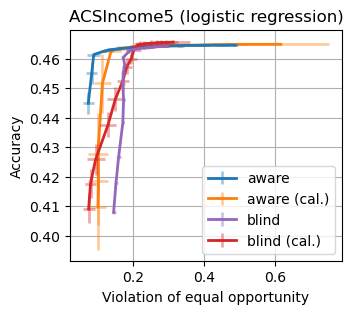

Results for attribute-aware setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.464564  0.000259   0.488157  0.009126       0.233915  0.004167
0.450  0.464588  0.000251   0.450973  0.021557       0.217400  0.009583
0.400  0.464589  0.000257   0.401793  0.015439       0.198790  0.005071
0.350  0.464564  0.000255   0.381539  0.011046       0.192639  0.005470
0.300  0.464478  0.000267   0.334663  0.009405       0.170356  0.003829
0.250  0.464267  0.000269   0.286500  0.012983       0.151392  0.004589
0.200  0.464098  0.000284   0.242779  0.017851       0.135961  0.006071
0.180  0.463978  0.000283   0.224463  0.015377       0.131262  0.005412
0.150  0.463815  0.000291   0.198752  0.013342       0.122907  0.005233
0.100  0.463318  0.000313   0.152961  0.012929       0.098010  0.004396
0.080  0.462989  0.000309   0.131966  0.013632       0.086910  0.004799
0.050  0.462561  0.000353   0.118502  0.008948       0.077085  0.004356
0.020  0.461419  0.000659   0.089380  0.018801       0.056652  0.004992
0.010  0.455026  0.003730   0.083529  0.015212       0.049174  0.006564
0.001  0.444919  0.003696   0.073897  0.015342       0.040630  0.006665

Results for attribute-aware setting with calibration:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.464891  0.000348   0.616049  0.137275       0.328870  0.076787
0.450  0.464864  0.000267   0.472827  0.051374       0.270563  0.035250
0.400  0.464751  0.000214   0.424140  0.040460       0.253171  0.038274
0.350  0.464594  0.000107   0.379166  0.039783       0.234907  0.042365
0.300  0.464558  0.000160   0.335372  0.042124       0.209239  0.034177
0.250  0.464443  0.000208   0.293653  0.043545       0.181840  0.024958
0.200  0.464284  0.000439   0.247140  0.041875       0.157589  0.022897
0.180  0.464119  0.000424   0.224455  0.039765       0.147504  0.021144
0.150  0.463915  0.000436   0.196782  0.043176       0.129383  0.023698
0.100  0.463301  0.000391   0.155273  0.029775       0.097615  0.015553
0.080  0.462637  0.000755   0.138166  0.029310       0.085273  0.013796
0.050  0.451645  0.010127   0.113822  0.023483       0.071809  0.015003
0.020  0.427728  0.013975   0.101054  0.029249       0.055172  0.013667
0.010  0.418575  0.014728   0.102275  0.028512       0.051684  0.013229
0.001  0.409891  0.014747   0.101141  0.021999       0.050692  0.013058

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.464183  0.000329   0.297076  0.003070       0.142190  0.000590
0.300  0.463992  0.000379   0.254195  0.006396       0.119160  0.002719
0.280  0.463815  0.000373   0.245559  0.006723       0.114188  0.003014
0.260  0.463656  0.000395   0.232323  0.007686       0.108420  0.001830
0.240  0.463501  0.000386   0.217130  0.006701       0.107280  0.001732
0.220  0.463246  0.000419   0.204487  0.006869       0.108162  0.002219
0.200  0.462732  0.000386   0.188686  0.005017       0.107413  0.002336
0.180  0.462218  0.000407   0.186558  0.006007       0.106430  0.002577
0.150  0.460468  0.000404   0.172778  0.005943       0.101939  0.002392
0.120  0.457971  0.000314   0.176598  0.005994       0.090365  0.002707
0.100  0.455283  0.000327   0.172895  0.006927       0.085485  0.001602
0.080  0.451563  0.000412   0.170982  0.006158       0.082831  0.002040
0.060  0.446142  0.000489   0.173478  0.004461       0.081206  0.002226
0.040  0.438428  0.000500   0.171404  0.003643       0.080071  0.002911
0.020  0.426881  0.000384   0.159634  0.006372       0.079795  0.003220
0.010  0.417965  0.000222   0.152092  0.006144       0.073797  0.002743
0.001  0.407962  0.000526   0.145312  0.005861       0.067691  0.002578

Results for attribute-blind setting with calibration:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.465620  0.000633   0.312704  0.047393       0.158065  0.023278
0.300  0.465536  0.000736   0.293419  0.033159       0.148227  0.015578
0.280  0.465467  0.000793   0.280370  0.028276       0.142742  0.010646
0.260  0.465373  0.000867   0.267559  0.026192       0.137352  0.007140
0.240  0.465251  0.000959   0.250093  0.023026       0.130241  0.003213
0.220  0.465062  0.001012   0.232209  0.020587       0.123230  0.003481
0.200  0.464929  0.001035   0.220531  0.016396       0.118426  0.005497
0.180  0.464364  0.001226   0.210350  0.019773       0.115120  0.008062
0.150  0.462820  0.001299   0.201038  0.020178       0.108199  0.006940
0.120  0.459941  0.001689   0.195135  0.015906       0.104761  0.007012
0.100  0.457206  0.002402   0.182210  0.013652       0.097519  0.008269
0.080  0.452624  0.003418   0.171611  0.017430       0.090564  0.007555
0.060  0.446228  0.004038   0.150032  0.023465       0.078704  0.008817
0.040  0.437689  0.004296   0.129820  0.021978       0.067710  0.009589
0.020  0.425879  0.005244   0.094587  0.025396       0.051402  0.008888
0.010  0.417734  0.005006   0.080253  0.016421       0.045072  0.004910
0.001  0.409124  0.004740   0.074839  0.016920       0.040777  0.007469

In [7]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08, 0.05,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08, 0.05,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1, 0.08,
        0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1, 0.08,
        0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eopp',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eopp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_eopp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eopp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

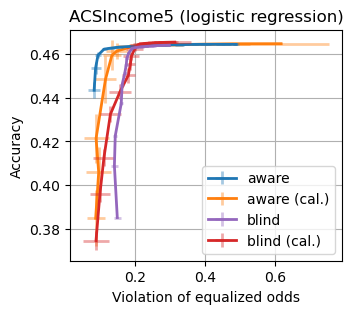

Results for attribute-aware setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.464564  0.000259  0.488157  0.009126     0.169337  0.001559
0.450  0.464588  0.000251  0.450973  0.021557     0.161099  0.006037
0.400  0.464594  0.000256  0.400814  0.016162     0.148662  0.006463
0.350  0.464572  0.000264  0.372035  0.011107     0.138506  0.004220
0.300  0.464439  0.000255  0.325761  0.012329     0.125238  0.003403
0.250  0.464296  0.000243  0.286376  0.011970     0.114282  0.003465
0.200  0.464123  0.000264  0.240433  0.011727     0.101814  0.002856
0.180  0.463986  0.000288  0.222237  0.015136     0.093979  0.004681
0.150  0.463773  0.000316  0.197796  0.016576     0.085184  0.003419
0.100  0.463287  0.000323  0.152081  0.012168     0.066584  0.003111
0.080  0.462883  0.000323  0.131640  0.011908     0.058852  0.003790
0.050  0.462403  0.000360  0.111080  0.007179     0.045101  0.003089
0.020  0.459585  0.001305  0.093621  0.009582     0.033969  0.003115
0.010  0.453637  0.002666  0.086800  0.014105     0.031011  0.003064
0.001  0.443530  0.003781  0.082721  0.016173     0.028271  0.003722

Results for attribute-aware setting with calibration:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.464891  0.000348  0.616049  0.137275     0.224908  0.047756
0.450  0.464864  0.000267  0.479090  0.048218     0.190688  0.027427
0.400  0.464765  0.000203  0.434992  0.035755     0.175722  0.027426
0.350  0.464648  0.000109  0.384106  0.040091     0.155647  0.026364
0.300  0.464537  0.000174  0.337971  0.045130     0.141411  0.016630
0.250  0.464393  0.000226  0.291652  0.045823     0.124487  0.014019
0.200  0.464179  0.000397  0.244497  0.043640     0.103861  0.011046
0.180  0.464093  0.000434  0.223209  0.040486     0.095590  0.009846
0.150  0.463797  0.000496  0.195989  0.043878     0.082472  0.009674
0.100  0.461556  0.003819  0.147990  0.031374     0.055359  0.007210
0.080  0.459550  0.006935  0.133346  0.024598     0.049254  0.007250
0.050  0.448458  0.010878  0.115056  0.030371     0.041840  0.007206
0.020  0.421421  0.011262  0.088244  0.035584     0.031847  0.009329
0.010  0.405844  0.011645  0.095726  0.035376     0.031128  0.008713
0.001  0.384703  0.012831  0.087088  0.025764     0.029301  0.006979

Results for attribute-blind setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.464183  0.000329  0.297076  0.003070     0.095359  0.001645
0.300  0.463992  0.000379  0.254195  0.006396     0.082550  0.001511
0.280  0.463815  0.000373  0.245559  0.006723     0.080142  0.001487
0.260  0.463656  0.000395  0.232323  0.007686     0.079279  0.000914
0.240  0.463501  0.000386  0.217130  0.006701     0.080208  0.000856
0.220  0.463246  0.000419  0.204487  0.006869     0.080712  0.000940
0.200  0.462732  0.000386  0.189870  0.002758     0.080244  0.000976
0.180  0.462218  0.000407  0.188737  0.002854     0.079703  0.001010
0.150  0.460537  0.000401  0.180962  0.003934     0.075316  0.001303
0.120  0.458189  0.000306  0.176060  0.005056     0.069662  0.001356
0.100  0.455285  0.000324  0.174400  0.007551     0.065877  0.001553
0.080  0.451330  0.000369  0.170056  0.006058     0.063244  0.001315
0.060  0.446055  0.000498  0.162548  0.006569     0.059095  0.002124
0.040  0.437431  0.000488  0.160053  0.005235     0.055734  0.001714
0.020  0.422542  0.000714  0.142947  0.005605     0.049980  0.001404
0.010  0.408838  0.000548  0.140510  0.010750     0.047035  0.001565
0.001  0.385051  0.000439  0.148763  0.009887     0.047809  0.001865

Results for attribute-blind setting with calibration:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.465620  0.000633  0.312704  0.047393     0.107247  0.013579
0.300  0.465527  0.000728  0.287067  0.033589     0.099487  0.009613
0.280  0.465448  0.000769  0.271523  0.025888     0.094884  0.006467
0.260  0.465332  0.000814  0.256739  0.020716     0.091140  0.004493
0.240  0.465174  0.000863  0.239568  0.018666     0.087594  0.003720
0.220  0.464962  0.000889  0.222432  0.019565     0.085152  0.004229
0.200  0.464818  0.000925  0.213190  0.019487     0.083595  0.004137
0.180  0.464280  0.001088  0.207572  0.021583     0.080831  0.003562
0.150  0.462414  0.000984  0.198106  0.023102     0.076812  0.000882
0.120  0.459089  0.001889  0.188980  0.022855     0.070154  0.002633
0.100  0.455587  0.002760  0.186270  0.013438     0.062240  0.005492
0.080  0.450388  0.003337  0.180192  0.018337     0.057620  0.006367
0.060  0.442870  0.003542  0.156566  0.031317     0.048425  0.007832
0.040  0.432451  0.003595  0.129062  0.029999     0.039998  0.006750
0.020  0.412552  0.003925  0.110678  0.032589     0.033570  0.005906
0.010  0.396072  0.003877  0.099322  0.027732     0.030134  0.004423
0.001  0.374462  0.004434  0.088101  0.038269     0.027733  0.005608

In [8]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08, 0.05,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08, 0.05,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1, 0.08,
        0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1, 0.08,
        0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eo',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eo',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_eo',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eo',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

## Gradient boosting decision tree

In [9]:
# Train attribute-aware p(Y | X) predictor
predictor_y = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Binned ECE of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Binned ECE of attribute-blind predictor: 1.606796182708655


In [10]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

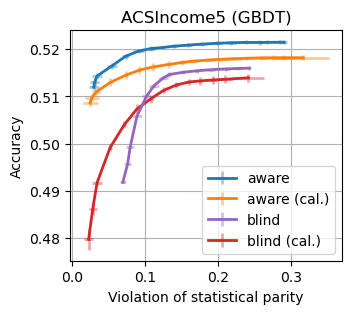

Results for attribute-aware setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.521496  0.000423  0.289463  0.001685     0.149497  0.001047
0.300  0.521491  0.000412  0.284226  0.010023     0.147538  0.004010
0.280  0.521466  0.000419  0.265982  0.003463     0.140807  0.000949
0.260  0.521443  0.000433  0.256917  0.005213     0.137679  0.002251
0.240  0.521450  0.000437  0.238389  0.007022     0.130742  0.002137
0.220  0.521397  0.000406  0.217848  0.006996     0.124566  0.002020
0.200  0.521269  0.000418  0.198174  0.006897     0.119288  0.001714
0.180  0.521098  0.000419  0.177993  0.006696     0.114950  0.001375
0.160  0.520880  0.000391  0.158128  0.005463     0.111640  0.000989
0.140  0.520668  0.000396  0.140050  0.004867     0.109752  0.001232
0.120  0.520382  0.000410  0.123794  0.002177     0.097770  0.004552
0.100  0.520163  0.000438  0.108141  0.005543     0.084486  0.002066
0.080  0.519641  0.000433  0.091331  0.007665     0.073108  0.001073
0.060  0.518547  0.000518  0.073364  0.005095     0.058096  0.003909
0.040  0.516542  0.000630  0.055035  0.007020     0.041582  0.004549
0.020  0.514308  0.000682  0.033937  0.006391     0.024618  0.004321
0.010  0.512968  0.000697  0.030602  0.005695     0.020196  0.003867
0.001  0.511999  0.000657  0.029554  0.006787     0.018295  0.004364

Results for attribute-aware setting with calibration:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.518199  0.000494  0.316205  0.035568     0.183963  0.020023
0.300  0.518224  0.000493  0.289733  0.015542     0.172434  0.022100
0.280  0.518210  0.000511  0.274598  0.013590     0.166226  0.025358
0.260  0.518186  0.000480  0.258130  0.008876     0.158432  0.025541
0.240  0.518090  0.000416  0.239194  0.009515     0.151331  0.025616
0.220  0.518008  0.000343  0.220180  0.012861     0.142402  0.022891
0.200  0.517873  0.000339  0.202389  0.012203     0.136455  0.019597
0.180  0.517686  0.000378  0.184036  0.010979     0.128179  0.016438
0.160  0.517498  0.000454  0.166084  0.006376     0.119881  0.012738
0.140  0.517203  0.000558  0.150615  0.005331     0.110605  0.008534
0.120  0.516789  0.000735  0.132291  0.004894     0.098460  0.003721
0.100  0.516253  0.000898  0.110376  0.004431     0.084821  0.002253
0.080  0.515565  0.000907  0.091906  0.002083     0.071296  0.002809
0.060  0.514539  0.000799  0.073779  0.002993     0.055943  0.001876
0.040  0.513001  0.000817  0.052428  0.002859     0.039615  0.002193
0.020  0.510955  0.000672  0.032873  0.005275     0.023160  0.003041
0.010  0.509747  0.000706  0.026977  0.010014     0.017613  0.004065
0.001  0.508663  0.000659  0.024581  0.010261     0.014353  0.004860

Results for attribute-blind setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.516004  0.000392  0.242301  0.002091     0.128875  0.000691
0.220  0.515934  0.000392  0.227412  0.006639     0.123908  0.002213
0.200  0.515837  0.000401  0.209926  0.005680     0.118315  0.001962
0.180  0.515677  0.000385  0.190590  0.004394     0.112758  0.001431
0.160  0.515445  0.000389  0.170507  0.003010     0.108123  0.001186
0.140  0.515111  0.000398  0.151208  0.003313     0.104837  0.001012
0.120  0.514656  0.000436  0.133089  0.003464     0.101972  0.001736
0.100  0.513921  0.000476  0.124622  0.005960     0.088455  0.001454
0.080  0.512287  0.000444  0.111992  0.006725     0.073438  0.000798
0.060  0.509995  0.000366  0.101596  0.005317     0.060665  0.002435
0.040  0.505835  0.000291  0.088683  0.006584     0.051535  0.004043
0.020  0.499299  0.000244  0.079450  0.005351     0.045514  0.003842
0.010  0.495644  0.000249  0.075855  0.004337     0.043215  0.003618
0.001  0.491812  0.000227  0.069340  0.004498     0.039626  0.003749

Results for attribute-blind setting with calibration:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.513960  0.000848  0.241087  0.020960     0.134051  0.005364
0.220  0.513643  0.000807  0.209818  0.010403     0.125378  0.005055
0.200  0.513500  0.000841  0.192981  0.005020     0.121055  0.005784
0.180  0.513301  0.000810  0.175303  0.002943     0.116723  0.005997
0.160  0.513061  0.000719  0.159813  0.001736     0.113791  0.005983
0.140  0.512444  0.000720  0.142738  0.003231     0.109760  0.004740
0.120  0.511289  0.000654  0.125184  0.001381     0.099472  0.002565
0.100  0.509504  0.000846  0.107562  0.003268     0.086206  0.002936
0.080  0.507318  0.001014  0.088407  0.002089     0.074183  0.000508
0.060  0.504042  0.000766  0.071430  0.002358     0.056534  0.000968
0.040  0.499156  0.000796  0.051900  0.002341     0.038928  0.000741
0.020  0.491727  0.000456  0.034076  0.006323     0.023240  0.003658
0.010  0.486126  0.001232  0.028126  0.005713     0.017852  0.004042
0.001  0.479702  0.002281  0.022517  0.005986     0.014632  0.005519

In [11]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1,
        0.08, 0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1,
        0.08, 0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
        0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
        0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_sp',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_sp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_sp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_sp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

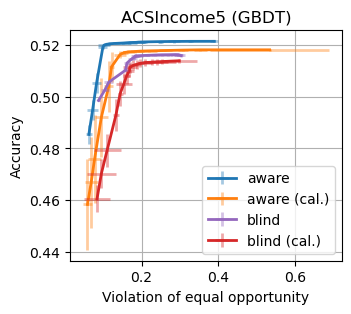

Results for attribute-aware setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.521496  0.000423   0.389024  0.010882       0.193589  0.004177
0.350  0.521489  0.000432   0.327109  0.007184       0.163661  0.003505
0.300  0.521446  0.000409   0.284670  0.015347       0.143601  0.006968
0.250  0.521389  0.000405   0.249233  0.005471       0.127749  0.001854
0.200  0.521266  0.000410   0.205165  0.010256       0.113416  0.002147
0.180  0.521191  0.000398   0.191791  0.016966       0.109521  0.002189
0.160  0.521096  0.000381   0.185969  0.019573       0.106766  0.001931
0.140  0.521003  0.000408   0.167211  0.020237       0.098937  0.003312
0.120  0.520837  0.000419   0.151986  0.021431       0.092234  0.001836
0.100  0.520663  0.000394   0.128449  0.014351       0.080148  0.002478
0.080  0.520374  0.000433   0.109957  0.008724       0.068679  0.001830
0.060  0.520013  0.000386   0.102474  0.016263       0.062220  0.007066
0.040  0.519235  0.000533   0.099516  0.012006       0.062069  0.004286
0.020  0.505388  0.003866   0.083186  0.012602       0.049080  0.006191
0.010  0.494988  0.003957   0.072941  0.013399       0.042451  0.006134
0.001  0.485430  0.003746   0.063108  0.007604       0.038632  0.004451

Results for attribute-aware setting with calibration:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.518199  0.000494   0.532800  0.154924       0.290201  0.062810
0.350  0.518201  0.000451   0.353021  0.016440       0.203743  0.018010
0.300  0.518094  0.000366   0.307190  0.012649       0.179663  0.018549
0.250  0.517940  0.000252   0.262098  0.017157       0.164582  0.025717
0.200  0.517790  0.000401   0.218184  0.020781       0.139989  0.016706
0.180  0.517689  0.000426   0.196727  0.009567       0.132310  0.010400
0.160  0.517556  0.000509   0.183576  0.013827       0.124612  0.008136
0.140  0.517405  0.000625   0.166101  0.014557       0.112229  0.005271
0.120  0.517122  0.000730   0.153941  0.010662       0.098189  0.004468
0.100  0.516358  0.001447   0.144112  0.016091       0.090522  0.006420
0.080  0.511609  0.005769   0.122055  0.005364       0.078847  0.005898
0.060  0.504014  0.009863   0.114672  0.011552       0.068792  0.009420
0.040  0.492075  0.015248   0.095551  0.016900       0.054575  0.006983
0.020  0.476030  0.017054   0.078089  0.016607       0.042464  0.006106
0.010  0.466831  0.017616   0.069097  0.016605       0.038461  0.004670
0.001  0.458281  0.017737   0.059515  0.012680       0.034274  0.003759

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.516004  0.000392   0.302683  0.011415       0.149020  0.003785
0.280  0.516333  0.000404   0.296037  0.010670       0.142847  0.003625
0.260  0.516366  0.000403   0.288502  0.011426       0.139042  0.004121
0.240  0.516305  0.000399   0.269370  0.009053       0.128463  0.003364
0.220  0.516280  0.000400   0.252684  0.008820       0.119461  0.003135
0.200  0.516179  0.000390   0.233900  0.008645       0.110230  0.002957
0.180  0.516063  0.000357   0.215959  0.007315       0.102023  0.002681
0.160  0.515948  0.000370   0.194346  0.009826       0.098001  0.001276
0.140  0.515865  0.000384   0.183813  0.009999       0.097513  0.001035
0.120  0.515771  0.000415   0.185291  0.009080       0.094180  0.001231
0.100  0.515224  0.000417   0.179846  0.007428       0.090301  0.002845
0.080  0.514551  0.000401   0.173244  0.009544       0.087435  0.004036
0.060  0.513125  0.000279   0.162449  0.006748       0.084204  0.002792
0.040  0.510263  0.000240   0.158139  0.006807       0.080718  0.002675
0.020  0.505685  0.000178   0.114870  0.011873       0.068365  0.003890
0.010  0.502546  0.000295   0.104373  0.010701       0.063958  0.002313
0.001  0.498578  0.000278   0.088310  0.004963       0.058952  0.002364

Results for attribute-blind setting with calibration:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.513960  0.000848   0.297838  0.045241       0.159416  0.022904
0.280  0.513643  0.001115   0.252015  0.037572       0.140152  0.012200
0.260  0.513560  0.001130   0.239623  0.030017       0.135527  0.010059
0.240  0.513426  0.001237   0.228108  0.024218       0.132894  0.010086
0.220  0.513254  0.001404   0.209134  0.017512       0.129422  0.009349
0.200  0.512994  0.001573   0.197268  0.010325       0.125895  0.008759
0.180  0.512622  0.001728   0.189365  0.009326       0.121918  0.007760
0.160  0.512209  0.001923   0.178866  0.011982       0.117846  0.008225
0.140  0.511390  0.002048   0.170006  0.017103       0.109630  0.009647
0.120  0.510128  0.002605   0.168268  0.012098       0.096663  0.007944
0.100  0.508176  0.003310   0.161411  0.008616       0.091798  0.001999
0.080  0.505145  0.004051   0.154279  0.021825       0.088701  0.004826
0.060  0.501178  0.004816   0.144294  0.006747       0.079968  0.005595
0.040  0.492803  0.006241   0.133236  0.007964       0.074804  0.008509
0.020  0.479332  0.006440   0.110613  0.035038       0.063018  0.010653
0.010  0.470204  0.005707   0.095533  0.038411       0.056874  0.011917
0.001  0.460453  0.005190   0.084287  0.034725       0.052096  0.011898

In [12]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.35, 0.3, 0.25, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06,
        0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.35, 0.3, 0.25, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06,
        0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08,
        0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08,
        0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eopp',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eopp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_eopp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eopp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

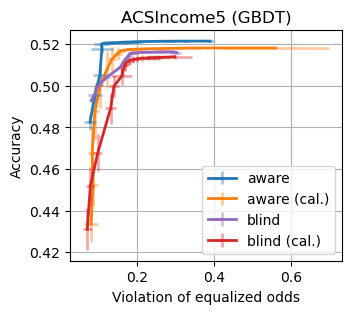

Results for attribute-aware setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.521496  0.000423  0.389024  0.010882     0.123070  0.001223
0.350  0.521489  0.000432  0.327109  0.007184     0.106015  0.001644
0.300  0.521446  0.000409  0.284670  0.015347     0.098079  0.000973
0.250  0.521389  0.000405  0.249233  0.005471     0.089383  0.000963
0.200  0.521253  0.000388  0.205234  0.010251     0.078908  0.000875
0.180  0.521180  0.000400  0.191569  0.016280     0.077931  0.000658
0.160  0.521061  0.000393  0.182546  0.013431     0.076474  0.001806
0.140  0.521030  0.000406  0.167689  0.019958     0.069786  0.002118
0.120  0.520824  0.000434  0.152878  0.023031     0.062484  0.001342
0.100  0.520685  0.000381  0.128229  0.012944     0.054152  0.001416
0.080  0.520432  0.000443  0.113237  0.008883     0.046217  0.001670
0.060  0.519964  0.000419  0.107757  0.019709     0.044417  0.004117
0.040  0.517590  0.001955  0.108991  0.027659     0.042920  0.005636
0.020  0.505313  0.003453  0.103871  0.018793     0.037079  0.005859
0.010  0.495723  0.003700  0.091263  0.017135     0.033268  0.004778
0.001  0.482698  0.003845  0.078502  0.015853     0.030617  0.004386

Results for attribute-aware setting with calibration:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.518199  0.000494  0.558673  0.139467     0.194798  0.037780
0.350  0.518202  0.000451  0.352123  0.016473     0.135513  0.014602
0.300  0.518087  0.000373  0.307490  0.012470     0.118544  0.016644
0.250  0.517935  0.000262  0.261914  0.017314     0.104192  0.020267
0.200  0.517761  0.000419  0.211731  0.015201     0.091252  0.012209
0.180  0.517606  0.000422  0.198954  0.015499     0.085727  0.008371
0.160  0.517461  0.000507  0.180756  0.009686     0.077831  0.004972
0.140  0.516956  0.000757  0.159613  0.012718     0.066243  0.006236
0.120  0.515423  0.003041  0.149755  0.010753     0.058106  0.003380
0.100  0.512874  0.005665  0.135191  0.011481     0.053409  0.004660
0.080  0.507907  0.008730  0.122071  0.005643     0.046849  0.003330
0.060  0.500203  0.010718  0.105242  0.006283     0.039734  0.005041
0.040  0.487676  0.013651  0.090995  0.010629     0.033926  0.003345
0.020  0.467599  0.012546  0.083893  0.011929     0.031198  0.001272
0.010  0.452376  0.010391  0.086128  0.013350     0.031436  0.002812
0.001  0.433457  0.008698  0.081120  0.017400     0.028219  0.005779

Results for attribute-blind setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.516004  0.000392  0.302683  0.011415     0.091413  0.001155
0.280  0.516333  0.000404  0.296037  0.010670     0.086830  0.000778
0.260  0.516366  0.000403  0.288502  0.011426     0.084729  0.000943
0.240  0.516305  0.000399  0.269370  0.009053     0.078496  0.000648
0.220  0.516280  0.000400  0.252684  0.008820     0.073537  0.000706
0.200  0.516180  0.000390  0.233900  0.008645     0.070798  0.000567
0.180  0.516070  0.000370  0.215982  0.007327     0.070659  0.000624
0.160  0.515949  0.000419  0.195305  0.010281     0.070446  0.000507
0.140  0.515790  0.000442  0.185778  0.009083     0.070102  0.000620
0.120  0.515587  0.000429  0.184458  0.008830     0.066446  0.000513
0.100  0.514963  0.000467  0.179548  0.006892     0.059249  0.001458
0.080  0.514027  0.000413  0.176097  0.008320     0.048978  0.001209
0.060  0.512190  0.000323  0.167536  0.007269     0.045941  0.001193
0.040  0.508926  0.000261  0.156508  0.006773     0.043008  0.001157
0.020  0.504203  0.000089  0.122704  0.008711     0.038334  0.000927
0.010  0.500532  0.000142  0.102112  0.008983     0.033936  0.000940
0.001  0.492968  0.000175  0.082060  0.006507     0.030468  0.000862

Results for attribute-blind setting with calibration:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.513960  0.000848  0.297838  0.045241     0.105230  0.010144
0.280  0.513643  0.001115  0.255380  0.030696     0.094988  0.006948
0.260  0.513560  0.001130  0.243300  0.022104     0.093795  0.006276
0.240  0.513426  0.001237  0.231977  0.016194     0.092824  0.005980
0.220  0.513254  0.001404  0.213459  0.011603     0.090661  0.006093
0.200  0.512991  0.001579  0.200191  0.007555     0.088207  0.007011
0.180  0.512661  0.001606  0.190889  0.007221     0.084307  0.006584
0.160  0.512166  0.001789  0.180160  0.010946     0.079390  0.004991
0.140  0.511192  0.002008  0.170882  0.012791     0.073828  0.003157
0.120  0.509926  0.002676  0.169232  0.009965     0.063136  0.004149
0.100  0.507985  0.003121  0.163585  0.008259     0.056829  0.004554
0.080  0.504613  0.004348  0.160360  0.027881     0.050870  0.002541
0.060  0.499920  0.005405  0.140505  0.013903     0.044232  0.003587
0.040  0.489162  0.007309  0.131699  0.014054     0.041560  0.004236
0.020  0.467855  0.008810  0.098493  0.011781     0.035468  0.004100
0.010  0.451698  0.009460  0.079101  0.009937     0.030003  0.003511
0.001  0.431019  0.010064  0.071278  0.012124     0.026250  0.002786

In [13]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.35, 0.3, 0.25, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06,
        0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.35, 0.3, 0.25, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06,
        0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08,
        0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08,
        0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eo',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eo',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_eo',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eo',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

## ReLU network

In [14]:
# Train attribute-aware p(Y | X) predictor
predictor_y = MLPClassifier(hidden_layer_sizes=(500, 200, 100),
                            activation=torch.nn.ReLU(),
                            n_classes=n_classes,
                            n_epochs=20,
                            batch_size=128,
                            lr=1e-3,
                            gamma=0.8,
                            device=device,
                            random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = MLPClassifier(hidden_layer_sizes=(500, 200, 100),
                               activation=torch.nn.ReLU(),
                               n_classes=n_groups * n_classes,
                               n_epochs=20,
                               batch_size=128,
                               lr=1e-3,
                               gamma=0.8,
                               device=device,
                               random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Binned ECE of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Binned ECE of attribute-blind predictor: 0.7575289315826994


In [15]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

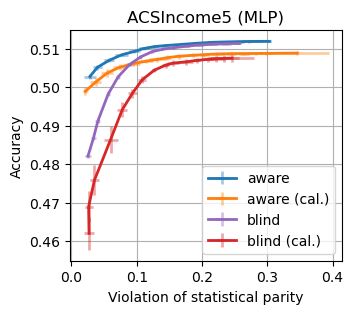

Results for attribute-aware setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.511887  0.000290  0.302706  0.003409     0.159909  0.001841
0.300  0.511880  0.000273  0.289574  0.015806     0.154928  0.006594
0.280  0.511860  0.000283  0.272268  0.011950     0.147632  0.006202
0.260  0.511814  0.000257  0.255931  0.008861     0.139771  0.005290
0.240  0.511740  0.000275  0.237595  0.009890     0.133387  0.004936
0.220  0.511652  0.000263  0.217823  0.009082     0.128305  0.004693
0.200  0.511456  0.000266  0.197505  0.007274     0.124026  0.004467
0.180  0.511223  0.000272  0.178243  0.007366     0.120806  0.004719
0.160  0.510982  0.000274  0.159317  0.007585     0.118013  0.004637
0.140  0.510778  0.000268  0.142363  0.007363     0.112395  0.004353
0.120  0.510504  0.000310  0.126428  0.007049     0.099138  0.004784
0.100  0.510035  0.000310  0.110952  0.007180     0.085656  0.003996
0.080  0.509267  0.000389  0.096287  0.008290     0.076415  0.004600
0.060  0.508408  0.000438  0.077220  0.009866     0.059439  0.005151
0.040  0.506971  0.000506  0.057838  0.007393     0.042311  0.003726
0.020  0.505121  0.000565  0.039589  0.007138     0.026382  0.004287
0.001  0.502754  0.000585  0.028209  0.008840     0.018215  0.006293

Results for attribute-aware setting with calibration:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.508828  0.000490  0.345800  0.049127     0.185933  0.026105
0.300  0.508763  0.000480  0.298496  0.010467     0.169021  0.012787
0.280  0.508736  0.000485  0.282118  0.009975     0.164259  0.012474
0.260  0.508720  0.000477  0.264060  0.007440     0.158918  0.011963
0.240  0.508701  0.000469  0.244516  0.007790     0.152959  0.009462
0.220  0.508602  0.000470  0.223619  0.007807     0.147946  0.008398
0.200  0.508446  0.000512  0.203338  0.006734     0.142206  0.009866
0.180  0.508255  0.000523  0.185479  0.007152     0.134169  0.009601
0.160  0.508014  0.000633  0.164686  0.006752     0.125713  0.005559
0.140  0.507646  0.000690  0.146458  0.005857     0.116697  0.005100
0.120  0.507197  0.000669  0.131670  0.013182     0.104150  0.006857
0.100  0.506733  0.000532  0.114482  0.011012     0.087955  0.005328
0.080  0.506096  0.000620  0.094605  0.010333     0.072586  0.004046
0.060  0.505183  0.000822  0.074112  0.009894     0.057502  0.003318
0.040  0.503662  0.000980  0.054658  0.009100     0.041797  0.003794
0.020  0.501308  0.001038  0.036944  0.008847     0.025044  0.005344
0.001  0.498911  0.001071  0.021248  0.004215     0.013757  0.002313

Results for attribute-blind setting:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.511344  0.000246  0.256603  0.002466     0.134065  0.000748
0.260  0.511338  0.000254  0.253705  0.006328     0.132970  0.002212
0.240  0.511285  0.000255  0.236620  0.008244     0.126755  0.003058
0.220  0.511137  0.000282  0.217342  0.007456     0.120055  0.002572
0.200  0.510955  0.000276  0.197018  0.005803     0.114085  0.001794
0.180  0.510638  0.000299  0.177089  0.004939     0.109543  0.001531
0.160  0.510227  0.000309  0.156089  0.003986     0.106059  0.001172
0.140  0.509811  0.000294  0.139231  0.001699     0.104125  0.000991
0.120  0.509209  0.000349  0.123608  0.000991     0.097752  0.003041
0.100  0.507826  0.000466  0.105747  0.002190     0.083326  0.002113
0.080  0.505864  0.000457  0.089002  0.001779     0.070836  0.000878
0.060  0.502691  0.000510  0.071583  0.003355     0.054462  0.000973
0.040  0.498222  0.000409  0.056275  0.002549     0.039970  0.002086
0.020  0.491155  0.000381  0.040338  0.003608     0.025647  0.002381
0.010  0.486706  0.000348  0.033606  0.003704     0.019833  0.002391
0.001  0.482097  0.000390  0.025258  0.004411     0.014146  0.002444

Results for attribute-blind setting with calibration:


accuracy            delta_sp           delta_sp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.507520  0.000881  0.245573  0.033574     0.133695  0.009745
0.260  0.507452  0.000821  0.233397  0.022883     0.128224  0.006092
0.240  0.507358  0.000737  0.221980  0.013450     0.123674  0.005371
0.220  0.507233  0.000674  0.209886  0.007825     0.119620  0.007187
0.200  0.506921  0.000732  0.191766  0.005751     0.114536  0.008457
0.180  0.506567  0.000736  0.175242  0.010307     0.110051  0.008711
0.160  0.506246  0.000732  0.156090  0.009378     0.106096  0.007145
0.140  0.505705  0.000656  0.144194  0.005125     0.103791  0.005702
0.120  0.504369  0.000537  0.126578  0.003419     0.096992  0.005411
0.100  0.501875  0.000917  0.108195  0.006510     0.086440  0.001601
0.080  0.498394  0.001240  0.093335  0.006340     0.072845  0.002578
0.060  0.494114  0.001926  0.077706  0.007707     0.057256  0.001908
0.040  0.486393  0.003402  0.059954  0.010635     0.042630  0.002532
0.020  0.475840  0.003880  0.035173  0.006362     0.025944  0.003357
0.010  0.468981  0.004050  0.026251  0.006014     0.017957  0.003700
0.001  0.462014  0.004370  0.026891  0.007646     0.014798  0.003611

In [16]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1,
        0.08, 0.06, 0.04, 0.02, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1,
        0.08, 0.06, 0.04, 0.02, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06,
        0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06,
        0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp', 'delta_sp_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_sp',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_sp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_sp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_sp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (MLP)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

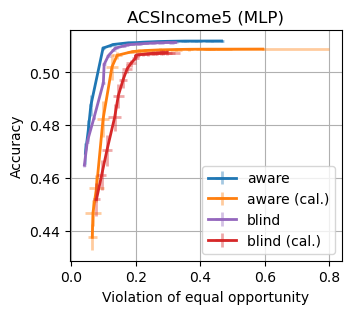

Results for attribute-aware setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.511887  0.000290   0.465690  0.007384       0.216361  0.002654
0.450  0.511878  0.000286   0.437031  0.021346       0.204320  0.009114
0.400  0.511861  0.000286   0.386236  0.017706       0.183800  0.006364
0.350  0.511860  0.000285   0.352481  0.011773       0.171338  0.005750
0.300  0.511780  0.000278   0.306899  0.019000       0.153312  0.007209
0.250  0.511672  0.000273   0.268585  0.014888       0.143824  0.002331
0.200  0.511426  0.000249   0.220817  0.012401       0.121719  0.005839
0.180  0.511273  0.000271   0.202050  0.009954       0.116220  0.004288
0.150  0.511210  0.000265   0.176752  0.011185       0.109700  0.004015
0.100  0.510556  0.000280   0.128798  0.009194       0.088647  0.002465
0.080  0.510107  0.000232   0.119847  0.004453       0.080445  0.004740
0.050  0.509204  0.000659   0.098336  0.007441       0.071994  0.005334
0.020  0.487485  0.003924   0.060422  0.004300       0.044624  0.003533
0.010  0.478039  0.003878   0.052407  0.004000       0.035853  0.003177
0.001  0.469412  0.003969   0.043637  0.003052       0.028667  0.003350

Results for attribute-aware setting with calibration:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.508828  0.000490   0.593450  0.205985       0.301350  0.078988
0.450  0.508792  0.000477   0.455792  0.041771       0.242742  0.018516
0.400  0.508798  0.000466   0.427053  0.019147       0.232784  0.015354
0.350  0.508750  0.000486   0.365730  0.010314       0.216958  0.020523
0.300  0.508664  0.000507   0.323306  0.018985       0.196963  0.022310
0.250  0.508525  0.000627   0.273886  0.028293       0.173947  0.015684
0.200  0.508283  0.000712   0.228896  0.019799       0.159386  0.018371
0.180  0.508131  0.000753   0.209890  0.020839       0.146890  0.014360
0.150  0.507859  0.000670   0.189063  0.016845       0.129077  0.012743
0.100  0.506449  0.001242   0.141903  0.015091       0.096075  0.007579
0.080  0.502092  0.004864   0.125918  0.018429       0.085150  0.010444
0.050  0.482339  0.006784   0.098326  0.017522       0.063511  0.009150
0.020  0.456104  0.005207   0.077689  0.022487       0.043466  0.010825
0.010  0.446852  0.004970   0.066950  0.023646       0.039493  0.011655
0.001  0.437612  0.004892   0.064922  0.013668       0.037201  0.010386

Results for attribute-blind setting:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.511344  0.000246   0.322737  0.008611       0.162878  0.003725
0.320  0.511309  0.000259   0.309998  0.008421       0.155473  0.004314
0.300  0.511321  0.000235   0.297356  0.008130       0.147956  0.004593
0.280  0.511228  0.000256   0.277254  0.009035       0.137459  0.004864
0.260  0.511145  0.000265   0.253099  0.008092       0.126021  0.003882
0.240  0.510967  0.000265   0.233666  0.007643       0.116792  0.003810
0.220  0.510793  0.000261   0.209718  0.008306       0.107342  0.003556
0.200  0.510623  0.000255   0.191885  0.005895       0.102049  0.002301
0.180  0.510417  0.000266   0.172612  0.004915       0.098101  0.002406
0.150  0.510065  0.000274   0.163829  0.006409       0.095680  0.001821
0.120  0.509200  0.000330   0.136857  0.006782       0.089879  0.002100
0.100  0.508392  0.000284   0.130308  0.008690       0.080664  0.002411
0.080  0.506368  0.000253   0.115092  0.007319       0.074511  0.004086
0.060  0.503027  0.000330   0.101665  0.006776       0.066343  0.004094
0.040  0.496050  0.000399   0.099252  0.006607       0.059087  0.003142
0.020  0.482689  0.000494   0.069946  0.004608       0.043351  0.003310
0.010  0.473815  0.000544   0.049492  0.004409       0.031773  0.002901
0.001  0.464972  0.000614   0.040407  0.005497       0.024167  0.001956

Results for attribute-blind setting with calibration:


accuracy           delta_eopp           delta_eopp_rms          
           mean       std       mean       std           mean       std
alpha                                                                  
inf    0.507520  0.000881   0.296463  0.041037       0.159726  0.017464
0.320  0.507501  0.000895   0.285660  0.036331       0.153167  0.013452
0.300  0.507451  0.000859   0.278729  0.032315       0.148807  0.012487
0.280  0.507338  0.000780   0.266400  0.025299       0.141661  0.010959
0.260  0.507216  0.000732   0.253288  0.022697       0.133973  0.011033
0.240  0.507042  0.000674   0.239142  0.025512       0.126876  0.013164
0.220  0.506849  0.000680   0.222335  0.016558       0.118309  0.011010
0.200  0.506664  0.000718   0.205321  0.008815       0.112007  0.008211
0.180  0.506371  0.000757   0.199105  0.004229       0.108185  0.006952
0.150  0.505363  0.001063   0.198724  0.010501       0.103667  0.006060
0.120  0.503485  0.001365   0.185190  0.015946       0.099298  0.007644
0.100  0.501338  0.001731   0.172884  0.016136       0.091660  0.005810
0.080  0.497310  0.003132   0.160608  0.012344       0.085715  0.004255
0.060  0.491189  0.004576   0.145540  0.017484       0.078955  0.005169
0.040  0.482973  0.005000   0.134228  0.019373       0.072001  0.005740
0.020  0.470491  0.005853   0.110213  0.016358       0.058087  0.004511
0.010  0.461220  0.005790   0.094076  0.013692       0.053562  0.006273
0.001  0.451921  0.006204   0.077809  0.009605       0.045134  0.006051

In [17]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08, 0.05,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08, 0.05,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1,
        0.08, 0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1,
        0.08, 0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp', 'delta_eopp_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eopp',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eopp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_eopp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eopp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (MLP)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

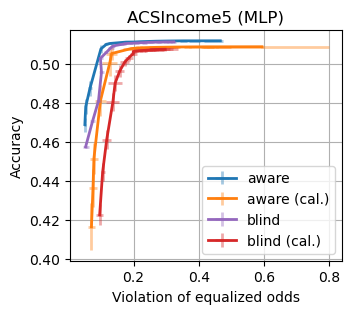

Results for attribute-aware setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.511887  0.000290  0.465690  0.007384     0.142074  0.001457
0.450  0.511878  0.000286  0.437031  0.021346     0.134833  0.005794
0.400  0.511861  0.000286  0.386236  0.017706     0.122730  0.004850
0.350  0.511860  0.000285  0.352481  0.011773     0.112952  0.002718
0.300  0.511780  0.000278  0.306899  0.019000     0.103535  0.002624
0.250  0.511672  0.000273  0.268585  0.014888     0.096363  0.002322
0.200  0.511426  0.000249  0.220817  0.012401     0.082133  0.001041
0.180  0.511273  0.000275  0.202095  0.009938     0.078581  0.001801
0.150  0.511216  0.000250  0.176834  0.010569     0.070778  0.001829
0.100  0.510532  0.000259  0.129045  0.008951     0.056445  0.003649
0.080  0.510089  0.000259  0.116700  0.006017     0.048267  0.003913
0.050  0.507729  0.002053  0.099863  0.004239     0.041945  0.004143
0.020  0.487498  0.003849  0.066386  0.006584     0.027966  0.003222
0.010  0.478023  0.003854  0.053312  0.002176     0.023251  0.002761
0.001  0.468833  0.003573  0.050695  0.003007     0.020968  0.003195

Results for attribute-aware setting with calibration:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.508828  0.000490  0.593450  0.205985     0.195474  0.041781
0.450  0.508792  0.000477  0.455792  0.041771     0.167733  0.008481
0.400  0.508798  0.000466  0.427053  0.019147     0.160703  0.009248
0.350  0.508746  0.000485  0.371806  0.017804     0.148658  0.014824
0.300  0.508666  0.000511  0.323104  0.019113     0.131964  0.015277
0.250  0.508538  0.000652  0.275620  0.027119     0.115661  0.010285
0.200  0.508315  0.000779  0.224192  0.025767     0.101575  0.009417
0.180  0.508168  0.000845  0.210271  0.017079     0.093495  0.008924
0.150  0.507830  0.000799  0.191063  0.022454     0.080247  0.008234
0.100  0.505348  0.003193  0.132774  0.017664     0.056138  0.002921
0.080  0.500598  0.006867  0.127146  0.023546     0.051089  0.005900
0.050  0.481035  0.007967  0.098327  0.017862     0.038334  0.004213
0.020  0.451384  0.007839  0.078437  0.012355     0.026881  0.003001
0.010  0.436345  0.009743  0.075626  0.013597     0.027445  0.004311
0.001  0.416361  0.012097  0.070906  0.010178     0.027808  0.002956

Results for attribute-blind setting:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.511344  0.000246  0.322737  0.008611     0.099618  0.001231
0.320  0.511309  0.000259  0.309998  0.008421     0.093845  0.002319
0.300  0.511321  0.000235  0.297356  0.008130     0.088098  0.002784
0.280  0.511228  0.000256  0.277254  0.009035     0.082540  0.001607
0.260  0.511145  0.000265  0.253099  0.008092     0.078334  0.001124
0.240  0.510967  0.000265  0.233666  0.007643     0.075150  0.001131
0.220  0.510793  0.000261  0.209718  0.008306     0.071993  0.001305
0.200  0.510623  0.000255  0.191885  0.005895     0.070722  0.000872
0.180  0.510417  0.000266  0.172612  0.004915     0.070807  0.000847
0.150  0.510067  0.000272  0.163821  0.006403     0.069645  0.000787
0.120  0.509220  0.000313  0.136612  0.006807     0.062457  0.000910
0.100  0.508292  0.000268  0.130164  0.008673     0.050794  0.000731
0.080  0.505960  0.000333  0.116689  0.006400     0.043538  0.002497
0.060  0.502892  0.000418  0.098337  0.007750     0.037190  0.002604
0.040  0.495709  0.000478  0.101592  0.008104     0.034064  0.001648
0.020  0.480944  0.000260  0.092383  0.008983     0.029569  0.003009
0.010  0.470442  0.000470  0.074065  0.008426     0.024694  0.001889
0.001  0.457431  0.000641  0.053057  0.009280     0.017530  0.002288

Results for attribute-blind setting with calibration:


accuracy            delta_eo           delta_eo_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.507520  0.000881  0.296463  0.041037     0.101547  0.011853
0.320  0.507501  0.000895  0.285660  0.036331     0.095730  0.008320
0.300  0.507451  0.000859  0.278729  0.032315     0.093100  0.008238
0.280  0.507338  0.000780  0.266400  0.025299     0.088974  0.008595
0.260  0.507216  0.000732  0.253288  0.022697     0.085736  0.007635
0.240  0.507042  0.000674  0.239142  0.025512     0.082882  0.007658
0.220  0.506837  0.000688  0.222333  0.016564     0.078841  0.006429
0.200  0.506617  0.000755  0.204822  0.009805     0.076302  0.004913
0.180  0.506356  0.000767  0.199035  0.004263     0.074425  0.004589
0.150  0.505252  0.001267  0.198582  0.010681     0.069377  0.005283
0.120  0.503202  0.001560  0.185666  0.013267     0.058696  0.004554
0.100  0.500882  0.001877  0.172691  0.013264     0.053905  0.003387
0.080  0.496316  0.002931  0.157377  0.014485     0.050065  0.002695
0.060  0.490084  0.004141  0.143370  0.022461     0.044303  0.004005
0.040  0.480477  0.004769  0.136562  0.020060     0.040873  0.003381
0.020  0.461105  0.004915  0.117631  0.013920     0.035497  0.002920
0.010  0.444348  0.004750  0.105115  0.006471     0.033006  0.003078
0.001  0.422473  0.005344  0.096056  0.009796     0.030976  0.002233

In [18]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08, 0.05,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08, 0.05,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1,
        0.08, 0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1,
        0.08, 0.06, 0.04, 0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo', 'delta_eo_rms'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eo',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eo',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_eo',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eo',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome5 (MLP)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)